In [ ]:
from typing_extensions import TypedDict
from typing import List
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-5-mini-2025-08-07")


In [13]:
class State(TypedDict):
    dish: str
    ingredients: list[dict]
    recipe_steps: str
    plating_instructions: str


class Ingredient(BaseModel):
    name: str
    quantity: str
    unit: str


class IngredientsOutput(BaseModel):
    ingredients: list[Ingredient]


In [14]:
def list_ingredients(state: State) -> State:
    structured_output = llm.with_structured_output(IngredientsOutput)
    response = structured_output.invoke(f"List 5-8 ingredients for {state['dish']}")

    return {"ingredients": response.ingredients}


def create_recipe(state: State) -> State:
    response = llm.invoke(
        f"Create a recipe for {state['dish']} with the following ingredients: {state['ingredients']}"
    )

    return {"recipe_steps": response.content}


def describe_plating(state: State) -> State:
    response = llm.invoke(
        f"Describe the plating for {state['dish']} with the following recipe: {state['recipe_steps']}"
    )

    return {"plating_instructions": response.content}


def gate(state: State) -> bool:
    ingredients = state["ingredients"]
    if len(ingredients) > 8 or len(ingredients) < 3:
        return False

    return True


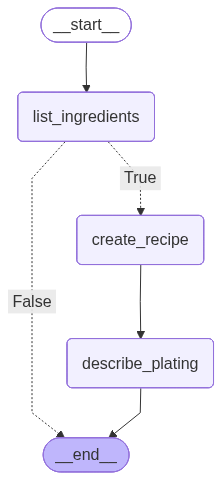

In [15]:
graph_builder = StateGraph(State)

graph_builder.add_node("list_ingredients", list_ingredients)
graph_builder.add_node("create_recipe", create_recipe)
graph_builder.add_node("describe_plating", describe_plating)

graph_builder.add_edge(START, "list_ingredients")
graph_builder.add_conditional_edges(
    "list_ingredients",
    gate,
    {
        True: "create_recipe",
        False: END,
    },
)
graph_builder.add_edge("create_recipe", "describe_plating")
graph_builder.add_edge("describe_plating", END)

graph = graph_builder.compile()

graph


In [10]:
graph.invoke({"dish": "pizza"})

{'dish': 'pizza',
 'ingredients': [Ingredient(name='Pizza dough', quantity='1', unit='ball'),
  Ingredient(name='Tomato sauce', quantity='1/2', unit='cup'),
  Ingredient(name='Mozzarella (shredded)', quantity='1 1/2', unit='cups'),
  Ingredient(name='Olive oil', quantity='1', unit='tablespoon'),
  Ingredient(name='Salt', quantity='1/2', unit='teaspoon'),
  Ingredient(name='Fresh basil leaves', quantity='8', unit='leaves'),
  Ingredient(name='Pepperoni slices', quantity='12', unit='slices')],
 'recipe_steps': 'Recipe: Classic Pepperoni Margherita-Style Pizza\nYields: 1 pizza (one dough ball, about 10–12" / 25–30 cm)\nPrep time: 15–30 minutes (plus 30–60 minutes if you bring dough to room temperature)\nCook time: 8–12 minutes\nTotal time: 23–102 minutes depending on dough temperature\n\nIngredients\n- 1 ball pizza dough (about 10–12" pizza)\n- 1/2 cup tomato sauce\n- 1 1/2 cups shredded mozzarella\n- 1 tablespoon olive oil\n- 1/2 teaspoon salt\n- 8 fresh basil leaves\n- 12 pepperoni slic